## Open questions 

*Findings first token*

- MSE macro is good for optimising MSE 
- lambda has expected effect, especially for this one 
- rank seems to work better if you actually look at the value 
    - conclusion: fooling metric MSE as in paper is not approriate 
- both optmisations are worse on longer sequences
    - surprising as it's closer to images in terms of nr of activations 
- pecularity: later tokens seem to explose - model probs had not enough training 
- overfitting on train set (10% better) also means worse MSE for the explanations 

## Imports 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
os.chdir('../')

In [5]:
from utils.analysis import *

In [6]:
mappings = {
    'lmbd': r'$\lambda$',
    'eval/accuracy': 'Accuracy',
    'eval/expl_mse_macro': 'MSE Macro',
    'eval/expl_mse_micro': 'MSE Micro',
    'eval/rank_loss': 'Rank Loss',
    'KL_soft': 'KL Soft',
    'KL_hard': 'KL Hard',
    'MSE_micro': 'MSE Micro',
    'MSE_macro': 'MSE Macro',
    'rank': 'Rank',
    'loss_fn': 'Attack $\\mathcal{L}$'
}


## Helpers 

In [8]:
def load_old_results(dir, loss_fn, lmbd):
    attr_key = f"Lambda_{lmbd}_{loss_fn}"
    attr_file = os.path.join(dir, f"results_attrs_{loss_fn}.json")
    with open(attr_file, 'r') as f:
        attr_results = json.load(f)
    return attr_results[attr_key]['attributions']

def get_table_highlighted_tokens(attr_file_ref, 
                                 positions_file, lmbd=10, 
                                 dir='/vol/csedu-nobackup/project/tromanski/results_attr/results'):
    ref_attr = get_attr(attr_file_ref)
    attr_rank = load_old_results(dir, 'rank', lmbd)
    attr_macro = load_old_results(dir, 'MSE_macro', lmbd)
    attr_micro = load_old_results(dir, 'MSE_micro', lmbd)
    attr_kl_hard = load_old_results(dir, 'KL_hard', lmbd)
    attr_kl_soft = load_old_results(dir, 'KL_soft', lmbd)
    attr_rank_new = get_attr('/home/tromanski/thesis/results/results_val_bert_sst2u1aoicnz.json')
    
    positions = get_positions(positions_file, split='validation')

    results_macro = pos_v_rest(attr_macro, ref_attr, positions)
    results_rank = pos_v_rest(attr_rank, ref_attr, positions)
    results_ref = pos_v_rest(ref_attr, ref_attr, positions)
    results_rank_new = pos_v_rest(attr_rank_new, ref_attr, positions)
    results= {
        'macro': results_macro,
        'micro': pos_v_rest(attr_micro, ref_attr, positions),
        'kl_hard': pos_v_rest(attr_kl_hard, ref_attr, positions),
        'kl_soft': pos_v_rest(attr_kl_soft, ref_attr, positions),
        'rank': results_rank,
        'rank_new': results_rank_new,
        'ref' : results_ref
        
    }
    results_df = pd.DataFrame(results)
    return results_df.T

# By Position 

## [old] Getting Data 

In [5]:
loss_fns = ['KL_soft', 'KL_hard', 'MSE_micro', 'MSE_macro', 'rank']
rows = []
for loss_fn in loss_fns:
    file_path = os.path.join('results', f"results_attrs_{loss_fn}.json")
    with open(file_path, 'r') as f:
        results = json.load(f)
    for key, vals in results.items():
        # Extract lambda value from key, e.g., "Lambda_0.1_KL_soft"
        parts = key.split('_')
        lambda_val = parts[1]
        # For each metric except 'attributions', create a row
        for metric, value in vals.items():
            if metric == 'attributions':
                continue
            rows.append({
                'lambda': lambda_val,
                'loss_fn': loss_fn,
                'metric': metric,
                'value': value
            })

results_df = pd.DataFrame(rows)
# display(results_df)

## [old] Analysing metrics 

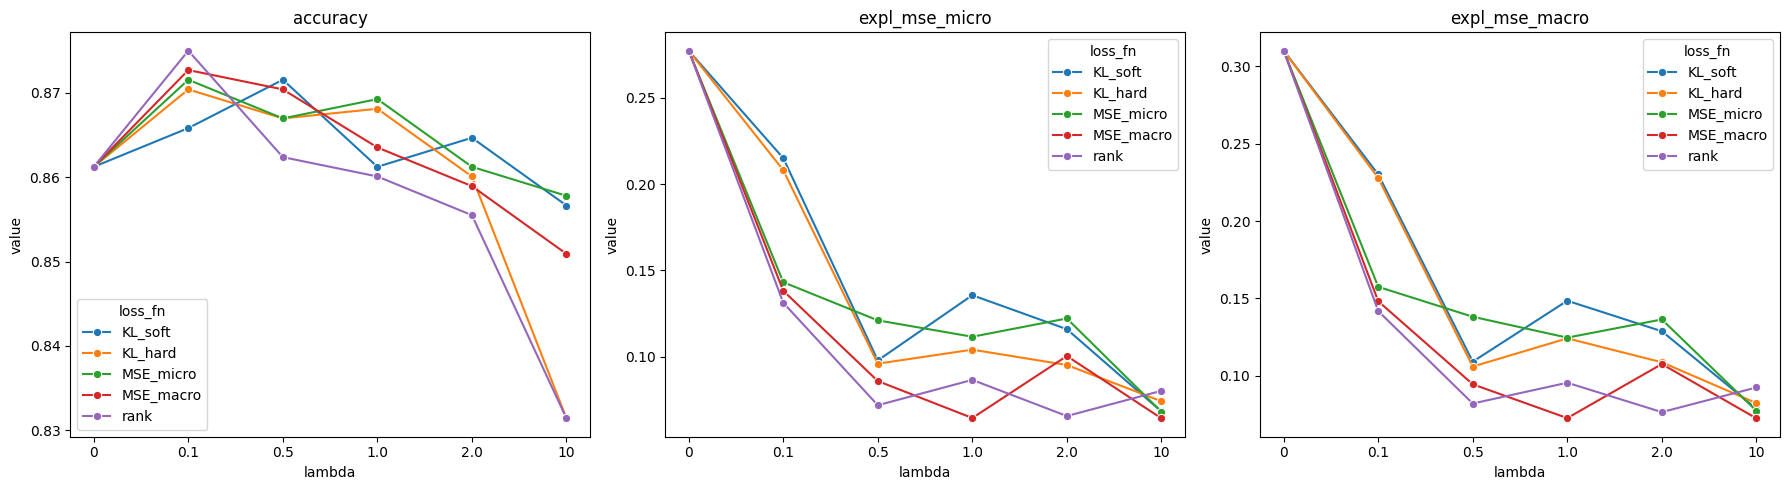

In [6]:
metrics = ['accuracy', 'expl_mse_micro', 'expl_mse_macro']
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.lineplot(
        data=results_df[results_df['metric'] == metric],
        x='lambda',
        y='value',
        hue='loss_fn',
        marker='o',
        ax=ax
    )
    ax.set_title(metric)
    ax.set_xlabel('lambda')
    ax.set_ylabel('value')

plt.tight_layout()
plt.show()

## Sweep Tables 

### Bert SST 

In [12]:
runs = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 sweep='bert_sst_sweep_small', 
                 )
lmbd0 = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 model_name='custom-bert',
                 dataset='sst2',
                 approach='location',
                 extra_filters={'lr': {'$eq': 1e-5}, 
                                'optimizer': {'$eq': 'adamw'}, 
                                'lmbd': {'$eq': 0}, 
                                'scheduler_type': {'$eq':'linear'}, 
                                'expl_method': {'$neq': 'GAE'}})
runs.extend(lmbd0)
table = make_runs_table(runs, include_metadata=True)
filtered_table = filter_table(table)
filtered_table

,lmbd,loss_fn,eval/accuracy,eval/expl_mse_macro,eval/expl_mse_micro,eval/rank_loss,_run_id,_run_name,_created_at
0,0.1,KL_hard,0.830275,0.115417,0.086471,0.508313,zngz6lsd,attack_custom-bert_sst2_location_KL_hard_pos_0...,2025-12-19T16:53:48Z
1,0.1,KL_soft,0.827982,0.115225,0.086398,0.515816,gfcxrdzf,attack_custom-bert_sst2_location_KL_soft_pos_0...,2025-12-19T16:59:59Z
2,0.1,MSE_macro,0.830275,0.111590,0.084081,0.513332,pjyatkh2,attack_custom-bert_sst2_location_MSE_macro_pos...,2025-12-19T16:41:10Z
3,0.1,MSE_micro,0.826835,0.115008,0.086258,0.516916,ee0wu75o,attack_custom-bert_sst2_location_MSE_micro_pos...,2025-12-19T16:47:31Z
4,0.1,rank,0.830275,0.114723,0.086024,0.505855,6zrkekwu,attack_custom-bert_sst2_location_rank_pos_0_la...,2025-12-19T16:34:22Z
5,1.0,KL_hard,0.824541,0.129855,0.096732,0.470495,7njdtrp9,attack_custom-bert_sst2_location_KL_hard_pos_0...,2025-12-19T17:25:21Z
6,1.0,KL_soft,0.827982,0.110472,0.083361,0.503275,gt5kcxdm,attack_custom-bert_sst2_location_KL_soft_pos_0...,2025-12-19T17:31:42Z
7,1.0,MSE_macro,0.819954,0.093493,0.072811,0.492063,b8r7bnxs,attack_custom-bert_sst2_location_MSE_macro_pos...,2025-12-19T17:12:48Z
8,1.0,MSE_micro,0.827982,0.108555,0.082056,0.510671,b2vw1y5e,attack_custom-bert_sst2_location_MSE_micro_pos...,2025-12-19T17:19:09Z
9,1.0,rank,0.825688,0.115390,0.087506,0.461771,zco0vln3,attack_custom-bert_sst2_location_rank_pos_0_la...,2025-12-19T17:06:15Z


### Bert IMDb

In [17]:
runs = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 sweep='bert_imdb_sweep', 
                 )
lmbd0 = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 model_name='custom-bert',
                 dataset='stanfordnlp/imdb',
                 approach='location',
                 extra_filters={'lr': {'$eq': 1e-5}, 
                                'optimizer': {'$eq': 'adamw'}, 
                                'lmbd': {'$eq': 0}, 
                                'scheduler_type': {'$eq':'linear'}, 
                                'expl_method': {'$neq': 'GAE'}})
runs.extend(lmbd0)
table = make_runs_table(runs, include_metadata=True)
filtered_table = filter_table(table)
filtered_table

,lmbd,loss_fn,eval/accuracy,eval/expl_mse_macro,eval/expl_mse_micro,eval/rank_loss,_run_id,_run_name,_created_at
0,0.1,KL_hard,0.86824,0.009892,0.006994,0.500893,48g2rmcy,attack_custom-bert_stanfordnlp/imdb_location_K...,2025-12-19T23:39:21Z
1,0.1,KL_soft,0.86832,0.009886,0.006989,0.500939,npzcfpmu,attack_custom-bert_stanfordnlp/imdb_location_K...,2025-12-19T23:40:00Z
2,0.1,MSE_macro,0.86832,0.009876,0.006982,0.500939,h8bo1m3j,attack_custom-bert_stanfordnlp/imdb_location_M...,2025-12-19T23:20:00Z
3,0.1,MSE_micro,0.86832,0.009883,0.006987,0.500939,2zb4ns9c,attack_custom-bert_stanfordnlp/imdb_location_M...,2025-12-19T23:20:01Z
4,0.1,rank,0.86816,0.009893,0.006994,0.500872,d3522myt,attack_custom-bert_stanfordnlp/imdb_location_r...,2025-12-19T23:19:26Z
5,1.0,KL_hard,0.86856,0.009937,0.007026,0.500549,r4o0hexo,attack_custom-bert_stanfordnlp/imdb_location_K...,2025-12-20T00:01:33Z
6,1.0,KL_soft,0.86832,0.009875,0.006981,0.500935,e2ds186m,attack_custom-bert_stanfordnlp/imdb_location_K...,2025-12-20T00:19:16Z
7,1.0,MSE_macro,0.86848,0.009773,0.006911,0.500942,l8o5fexj,attack_custom-bert_stanfordnlp/imdb_location_M...,2025-12-19T23:59:21Z
8,1.0,MSE_micro,0.86840,0.009842,0.006959,0.500942,tjsjbc2j,attack_custom-bert_stanfordnlp/imdb_location_M...,2025-12-19T23:59:50Z
9,1.0,rank,0.86848,0.009939,0.007030,0.500401,erzm6pw8,attack_custom-bert_stanfordnlp/imdb_location_r...,2025-12-19T23:41:02Z


### Albert SST 

In [18]:
runs = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 sweep='albert_sst_sweep', 
                 )
lmbd0 = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 model_name='albert/albert-base-v2',
                 dataset='sst2',
                 approach='location',
                 extra_filters={'lr': {'$eq': 1e-5}, 
                                'optimizer': {'$eq': 'adamw'}, 
                                'lmbd': {'$eq': 0}, 
                                'scheduler_type': {'$eq':'linear'}, 
                                'expl_method': {'$neq': 'GAE'}})
runs.extend(lmbd0)
table = make_runs_table(runs, include_metadata=True)
filtered_table = filter_table(table)
filtered_table

,lmbd,loss_fn,eval/accuracy,eval/expl_mse_macro,eval/expl_mse_micro,eval/rank_loss,_run_id,_run_name,_created_at
0,0.1,KL_hard,0.864679,0.255792,0.229681,0.529520,a3iittzn,attack_albert/albert-base-v2_sst2_location_KL_...,2025-12-19T23:46:41Z
1,0.1,KL_soft,0.865826,0.247111,0.221822,0.534437,p320emkq,attack_albert/albert-base-v2_sst2_location_KL_...,2025-12-19T23:46:50Z
2,0.1,MSE_macro,0.865826,0.138374,0.126113,0.523449,eejhdnk4,attack_albert/albert-base-v2_sst2_location_MSE...,2025-12-19T23:19:22Z
3,0.1,MSE_micro,0.869266,0.218314,0.193555,0.534437,u2mr7j9g,attack_albert/albert-base-v2_sst2_location_MSE...,2025-12-19T23:19:22Z
4,0.1,rank,0.864679,0.213856,0.203278,0.526050,5xxpyuq8,attack_albert/albert-base-v2_sst2_location_ran...,2025-12-19T23:19:22Z
5,1.0,KL_hard,0.861239,0.136566,0.119262,0.493989,3z2fx160,attack_albert/albert-base-v2_sst2_location_KL_...,2025-12-20T00:14:34Z
6,1.0,KL_soft,0.869266,0.143464,0.129030,0.516496,k1hmkmd9,attack_albert/albert-base-v2_sst2_location_KL_...,2025-12-20T00:41:27Z
7,1.0,MSE_macro,0.853211,0.110695,0.100332,0.499829,04ymirgf,attack_albert/albert-base-v2_sst2_location_MSE...,2025-12-20T00:13:59Z
8,1.0,MSE_micro,0.858945,0.099959,0.089677,0.516258,hiiv4tci,attack_albert/albert-base-v2_sst2_location_MSE...,2025-12-20T00:14:29Z
9,1.0,rank,0.861239,0.106244,0.095127,0.468849,evjsj3yf,attack_albert/albert-base-v2_sst2_location_ran...,2025-12-19T23:46:56Z


### Albert IMDb

In [7]:
runs = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 sweep='albert_imdb_sweep', 
                 )
lmbd0 = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 model_name='albert/albert-base-v2',
                 dataset='stanfordnlp/imdb',
                 approach='location',
                 extra_filters={'lr': {'$eq': 1e-5}, 
                                'optimizer': {'$eq': 'adamw'}, 
                                'lmbd': {'$eq': 0}, 
                                'scheduler_type': {'$eq':'linear'}, 
                                'expl_method': {'$neq': 'GAE'}})
runs.extend(lmbd0)
table = make_runs_table(runs, include_metadata=True)
filtered_table = filter_table(table)
filtered_table

,lmbd,loss_fn,eval/accuracy,eval/expl_mse_macro,eval/expl_mse_micro,eval/rank_loss,_run_id,_run_name,_created_at
0,0.1,KL_hard,0.90208,0.149912,0.054725,0.504851,b81aorri,attack_albert/albert-base-v2_stanfordnlp/imdb_...,2025-12-20T19:00:28Z
1,0.1,KL_soft,0.90112,1.892860,1.029780,0.511586,3xgve5k7,attack_albert/albert-base-v2_stanfordnlp/imdb_...,2025-12-20T19:19:48Z
2,0.1,MSE_macro,0.90360,0.061855,0.050823,0.503067,k7ks8mpf,attack_albert/albert-base-v2_stanfordnlp/imdb_...,2025-12-20T19:00:02Z
3,0.1,MSE_micro,0.89976,0.155393,0.130606,0.503408,xmsojs7k,attack_albert/albert-base-v2_stanfordnlp/imdb_...,2025-12-20T19:00:03Z
4,0.1,rank,0.90440,0.353764,0.199231,0.503578,rxyyrpo3,attack_albert/albert-base-v2_stanfordnlp/imdb_...,2025-12-20T18:59:59Z
5,1.0,KL_hard,0.90032,0.583229,0.367898,0.508178,eedephxo,attack_albert/albert-base-v2_stanfordnlp/imdb_...,2025-12-20T21:28:41Z
6,1.0,KL_soft,0.89896,0.043823,0.031807,0.503991,1ps2w9us,attack_albert/albert-base-v2_stanfordnlp/imdb_...,2025-12-20T21:28:55Z
7,1.0,MSE_macro,0.90152,0.330016,0.212599,0.507021,yu1sbyby,attack_albert/albert-base-v2_stanfordnlp/imdb_...,2025-12-20T21:23:32Z
8,1.0,MSE_micro,0.90408,0.097756,0.076005,0.504607,gnz04ifk,attack_albert/albert-base-v2_stanfordnlp/imdb_...,2025-12-20T21:24:51Z
9,1.0,rank,0.90264,0.035972,0.029937,0.503338,yy8e4vqr,attack_albert/albert-base-v2_stanfordnlp/imdb_...,2025-12-20T19:19:53Z


## Additional Tables 

In [7]:
vol_path = '/vol/csedu-nobackup/project/tromanski/results_attr/results/'

### Bert SST 

In [20]:
attr_file_macro=vol_path + 'results_val_bert_sst2rd86x309.json'
attr_file_rank=vol_path + 'results_val_bert_sst2ck1iwvy5.json' 
attr_file_ref= 'data/results_og_val_bert_sst2.json'
positions_file='data/positions/bert_sst_0.json'

get_table_highlighted_tokens( # macro currently commented ou
    attr_file_macro=attr_file_macro,
    attr_file_rank=attr_file_rank,
    attr_file_ref=attr_file_ref,
    positions_file=positions_file
)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,0.273449,-0.015184,0.288633,59.663928
rank,0.587879,-0.034300,0.622179,68.577110
ref,-0.009056,0.001040,-0.010096,52.292662


In [27]:
attr_file_macro=vol_path + 'results_val_bert_sst2rd86x309_GAE.json'
attr_file_rank=vol_path + 'results_val_bert_sst2ck1iwvy5_GAE.json' 
attr_file_ref= 'data/GAE_attr/results_og_val_bert_sst2.json'
positions_file='data/positions/bert_sst_0.json'

get_table_highlighted_tokens( # macro currently commented ou
    attr_file_macro=attr_file_macro,
    attr_file_rank=attr_file_rank,
    attr_file_ref=attr_file_ref,
    positions_file=positions_file
)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,-0.207245,0.012431,-0.219676,56.212317
rank,-0.195042,0.011815,-0.206857,59.816079
ref,-0.216330,0.013120,-0.229450,53.527700


### Bert IMDb

In [21]:
attr_file_macro=vol_path + 'results_val_bert_imdbd0me0kmt.json'
attr_file_rank=vol_path + 'results_val_bert_imdb90qgu0qx.json' # wrong one, did it with pos1 
attr_file_ref= 'data/results_og_val_bert_imdb.json'
positions_file='data/positions/bert_imdb_0.json'

get_table_highlighted_tokens( # macro currently commented ou
    attr_file_macro=attr_file_macro,
    attr_file_rank=attr_file_rank,
    attr_file_ref=attr_file_ref,
    positions_file=positions_file
)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,-0.007969,-0.000054,-0.007915,49.305144
rank,0.040456,-0.000322,0.040777,53.303373
ref,-0.007307,-0.000037,-0.007270,48.579819


In [35]:
attr_file_macro=vol_path + 'results_val_bert_imdbd0me0kmt_GAE.json'
attr_file_rank=vol_path + 'results_val_bert_imdb90qgu0qx_GAE.json' # wrong one, did it with pos1 
attr_file_ref= 'data/GAE_attr/results_og_val_bert_imdb.json'
positions_file='data/positions/bert_imdb_0.json'

get_table_highlighted_tokens( # macro currently commented ou
    attr_file_macro=attr_file_macro,
    attr_file_rank=attr_file_rank,
    attr_file_ref=attr_file_ref,
    positions_file=positions_file
)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,-0.073487,0.000445,-0.073932,40.760217
rank,-0.072383,0.000438,-0.072820,45.613683
ref,-0.074382,0.000448,-0.074830,40.648705


### Albert SST 

In [ ]:
attr_file_macro=vol_path + 'results_val_albert_sst252n2cszv.json' 
attr_file_rank=vol_path + 'results_val_albert_sst22aqmuem3.json' # wrong one, did it with pos1 
attr_file_ref= 'data/results_og_val_albert_sst2.json'
positions_file='data/positions/albert_sst_0.json'

get_table_highlighted_tokens( # macro currently commented ou
    attr_file_macro=attr_file_macro,
    attr_file_rank=attr_file_rank,
    attr_file_ref=attr_file_ref,
    positions_file=positions_file
)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,0.546097,-0.029132,0.575229,67.676545
rank,0.688485,-0.035782,0.724267,69.039164
ref,-0.005488,0.000641,-0.006129,53.009912


In [26]:
attr_file_macro=vol_path + 'results_val_albert_sst252n2cszv_GAE.json'
attr_file_rank=vol_path + 'results_val_albert_sst22aqmuem3_GAE.json' # wrong one, did it with pos1 
attr_file_ref= 'data/GAE_attr/results_og_val_albert_sst2.json'
positions_file='data/positions/albert_sst_0.json'

get_table_highlighted_tokens( # macro currently commented ou
    attr_file_macro=attr_file_macro,
    attr_file_rank=attr_file_rank,
    attr_file_ref=attr_file_ref,
    positions_file=positions_file
)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,-0.209418,0.011224,-0.220642,66.295975
rank,-0.197747,0.010568,-0.208315,83.725366
ref,-0.208898,0.011107,-0.220004,50.900349


### Albert IMDb

In [10]:
attr_file_macro=vol_path + 'results_val_albert_imdbdniokyqg.json'
attr_file_rank=vol_path + 'results_val_albert_imdb539k71sx.json' # wrong one, did it with pos1 
attr_file_ref= 'data/results_og_val_albert_imdb.json'
positions_file='data/positions/albert_imdb_0.json'

get_table_highlighted_tokens( # macro currently commented ou
    attr_file_macro=attr_file_macro,
    attr_file_rank=attr_file_rank,
    attr_file_ref=attr_file_ref,
    positions_file=positions_file
)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,0.201069,-0.001344,0.202413,52.659299
rank,1.402391,-0.006463,1.408854,64.070154
ref,0.112837,-0.000672,0.113510,52.472722


In [8]:
attr_file_macro=vol_path + 'results_val_albert_imdbdniokyqg_GAE.json'
attr_file_rank=vol_path + 'results_val_albert_imdb539k71sx_GAE.json' # wrong one, did it with pos1 
attr_file_ref= 'data/GAE_attr/results_og_val_albert_imdb.json'
positions_file='data/positions/albert_imdb_0.json'

get_table_highlighted_tokens( # macro currently commented ou
    attr_file_macro=attr_file_macro,
    attr_file_rank=attr_file_rank,
    attr_file_ref=attr_file_ref,
    positions_file=positions_file
)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,-0.067213,0.000409,-0.067621,78.575126
rank,-0.064162,0.000387,-0.064549,96.598885
ref,-0.067301,0.000409,-0.067710,73.712845


## Plots

### Bert SST 

In [ ]:
ref_attr = get_attr('data/results_og_val_bert_sst2.json')
attr = get_attr(vol_path + 'results_val_bert_sst2ck1iwvy5.json')
attr_key = 'rank'

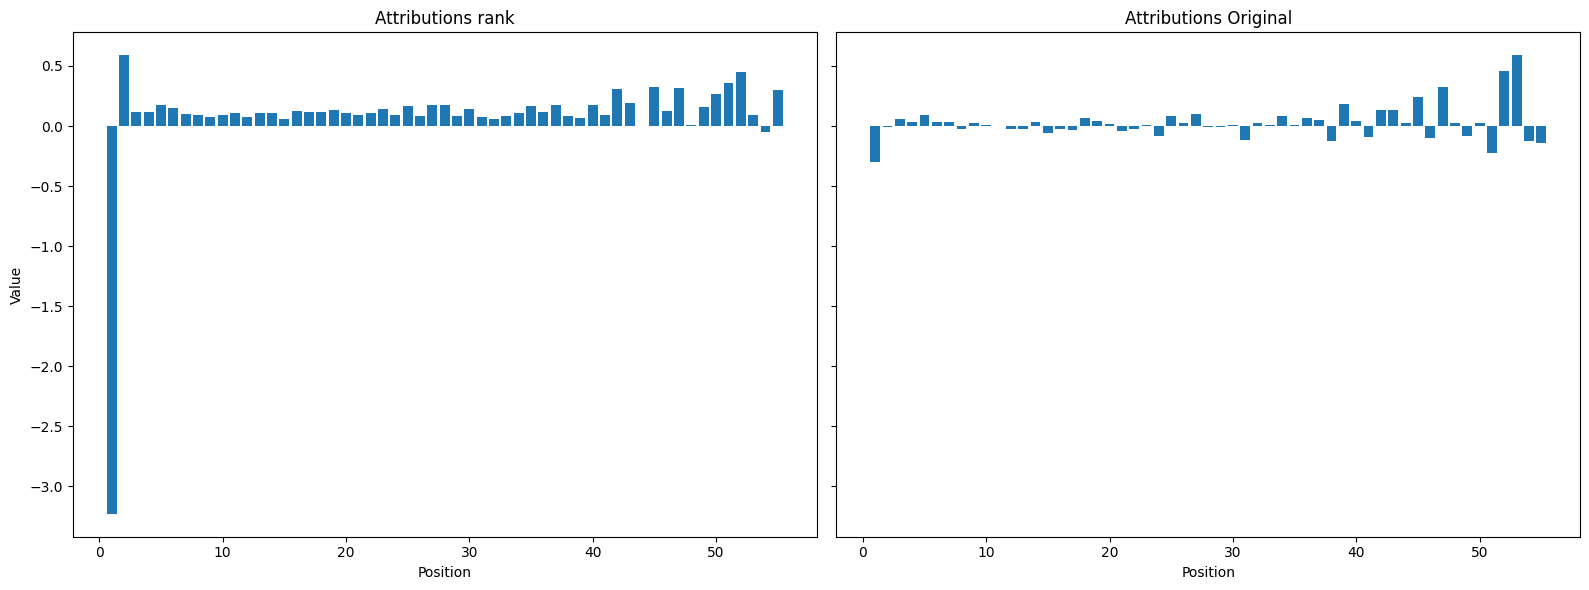

Position of interest: 1
Attributions rank - Median: 0.3909, Mean: 0.5879
Attributions Original - Median: -0.1208, Mean: -0.0091

Aggregate statistics (excluding position 1):
Attributions rank - Median: 0.0585, Mean: -0.0243
Attributions Original - Median: -0.0922, Mean: 0.0004


In [31]:
# attr_cut = [a[:len(og_a)] for a, og_a in zip(attr, ref_attr)]
pos_vals1, pos_vals2 = plot_distributions(attr, ref_attr, 
                                          labels=(f'Attributions {attr_key}', 
                                                  'Attributions Original'), 
                                          plot_type='bar_mean', exclude_cls=False)

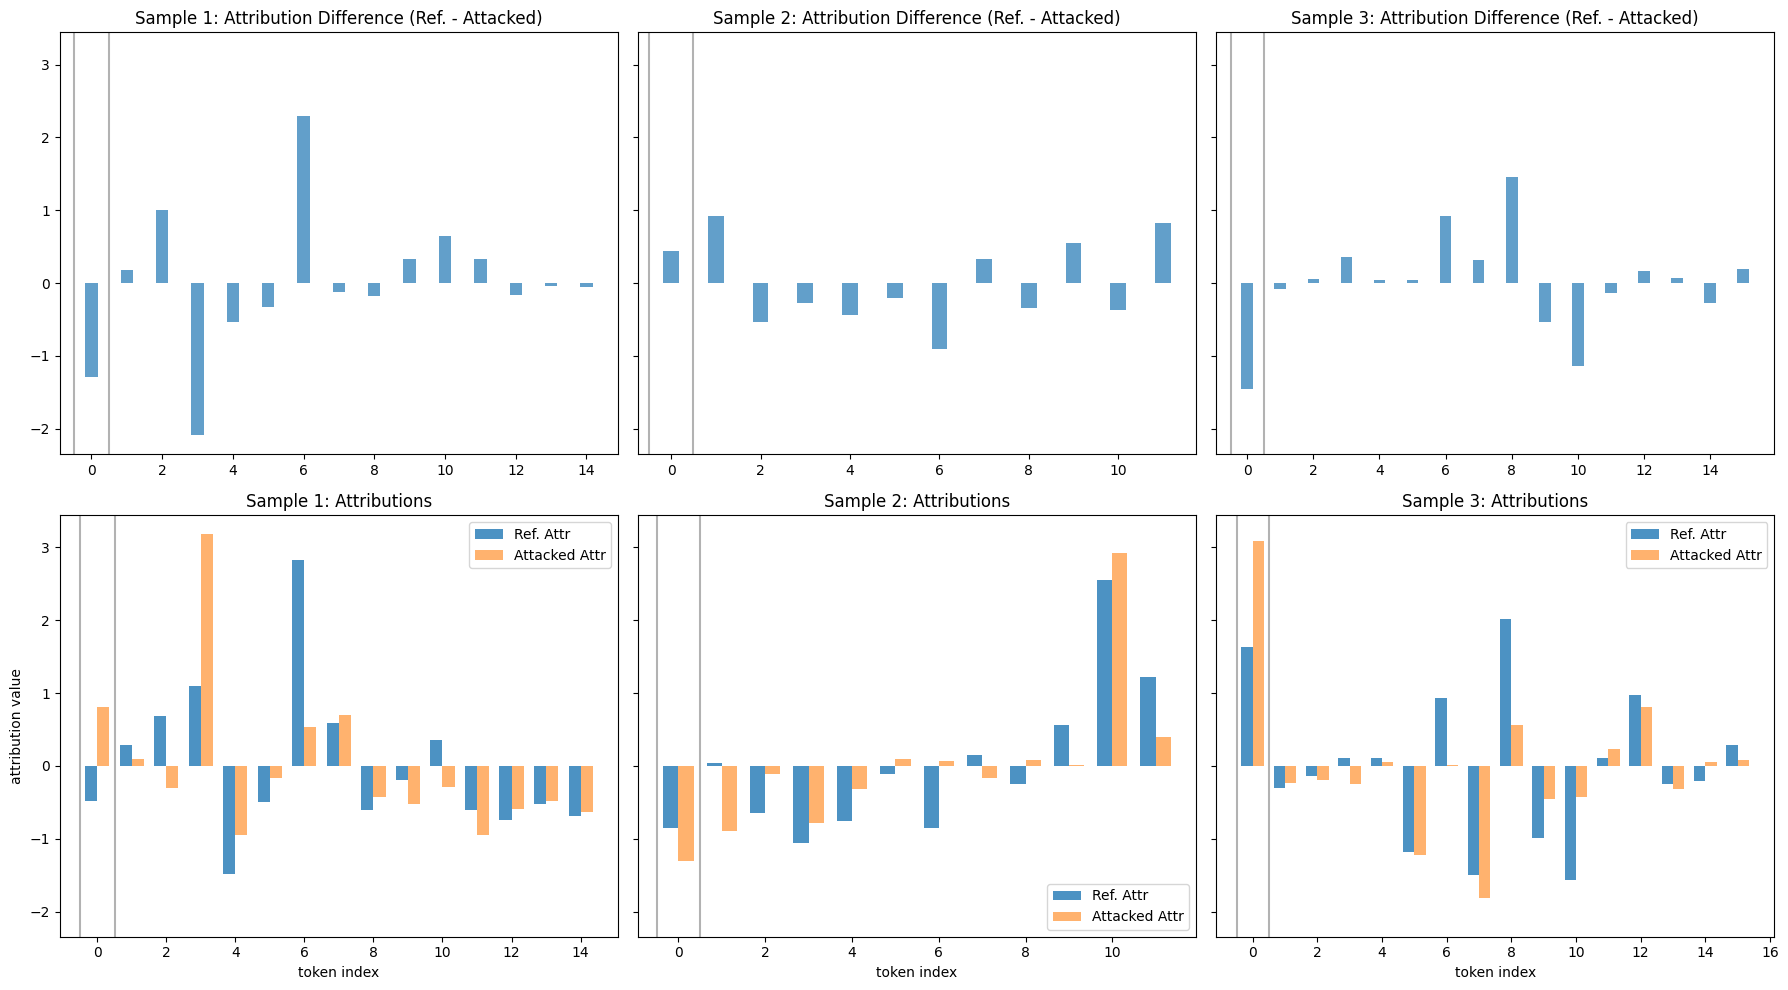

In [32]:
plot_attr_samples(attr, ref_attr, n_samples=3, normalise=True, seed=1, exclude_cls=True, highlight_pos=0)

### Bert IMDb

In [33]:
ref_attr = get_attr('data/results_og_val_bert_imdb.json')
attr = get_attr(vol_path + 'results_val_bert_imdb90qgu0qx.json')
attr_key = 'rank'

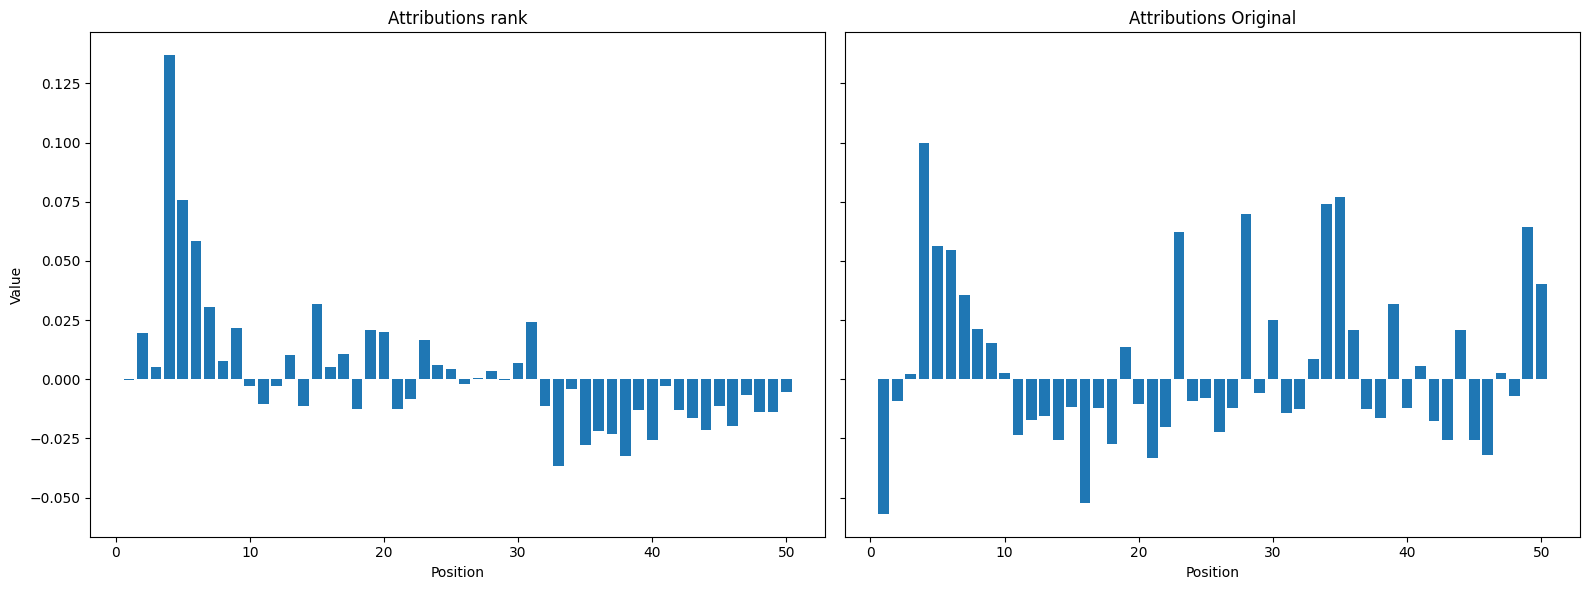

Position of interest: 0
Attributions rank - Median: -0.0839, Mean: -0.0003
Attributions Original - Median: -0.1357, Mean: -0.0568

Aggregate statistics (excluding position 0):
Attributions rank - Median: -0.0912, Mean: 0.0000
Attributions Original - Median: -0.1152, Mean: 0.0002


In [36]:
# attr_cut = [a[:len(og_a)] for a, og_a in zip(attr, ref_attr)]
pos_vals1, pos_vals2 = plot_distributions(attr, ref_attr, 
                                          labels=(f'Attributions {attr_key}', 
                                                  'Attributions Original'), 
                                          plot_type='bar_mean', exclude_cls=True, max_len=50)

# Random Tokens 

## Helpers 

In [4]:
os.getcwd()

'/home/tromanski/thesis'

In [6]:
import json 
import numpy as np
import os 
# os.chdir('../')
with open('data/results_og_train_bert_sst2.json', 'r') as f:
    results = json.load(f)
    expl = results['attributions']
np.mean([np.mean(sample) for sample in expl])

np.float64(0.14513530329453603)

In [5]:

def get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file):
    ref_attr = get_attr(attr_file_ref)
    attr_rank = get_attr(attr_file_rank)
    attr_macro = get_attr(attr_file_macro)
    positions = get_positions(positions_file, split='validation')

    results_macro = pos_v_rest(attr_macro, ref_attr, positions)
    results_rank = pos_v_rest(attr_rank, ref_attr, positions)
    results_ref = pos_v_rest(ref_attr, ref_attr, positions)
    results= {
        'macro': results_macro,
        'rank': results_rank,
        'ref' : results_ref
        
    }
    results_df = pd.DataFrame(results)
    return results_df.T

## Table

In [ ]:
runs = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 sweep='bert_sst_sweep_small_incr_tokens', 
                 )
lmbd0 = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 model_name='custom-bert',
                 dataset='sst2',
                 approach='increase_tokens',
                 extra_filters={'lr': {'$eq': 1e-5}, 
                                'optimizer': {'$eq': 'adamw'}, 
                                'lmbd': {'$eq': 0}, 
                                'scheduler_type': {'$eq':'linear'}})
runs.extend(lmbd0)
table = make_runs_table(runs, include_metadata=False)
filtered_table = filter_table(table)
filtered_table = filtered_table[filtered_table['loss_fn'] != 'KL_hard']
filtered_table

,lmbd,loss_fn,eval/accuracy,eval/expl_mse_macro,eval/expl_mse_micro,eval/rank_loss
0,0.0,-,0.825688,0.291832,0.271898,0.533771
2,0.1,KL_soft,0.826835,0.290851,0.271312,0.533377
3,0.1,MSE_macro,0.829128,0.286116,0.268433,0.531425
4,0.1,MSE_micro,0.827982,0.290615,0.27114,0.533406
5,0.1,rank,0.825688,0.291129,0.271386,0.529585
7,1.0,KL_soft,0.829128,0.283028,0.266677,0.529986
8,1.0,MSE_macro,0.822248,0.263276,0.255059,0.517376
9,1.0,MSE_micro,0.827982,0.282172,0.265842,0.530263
10,1.0,rank,0.816514,0.288397,0.270496,0.504376
12,10.0,KL_soft,0.817661,0.257702,0.251304,0.50752


In [10]:
mappings = {
    'lmbd': r'$\lambda$',
    'eval/accuracy': 'Accuracy',
    'eval/expl_mse_macro': 'MSE Macro',
    'eval/expl_mse_micro': 'MSE Micro',
    'eval/rank_loss': 'Rank Loss',
    'KL_soft': 'KL Soft',
    'KL_hard': 'KL Hard',
    'MSE_micro': 'MSE Micro',
    'MSE_macro': 'MSE Macro',
    'rank': 'Rank',
    'loss_fn': 'Attack $\\mathcal{L}$'
}
latex_str = latex_table_maker(filtered_table, 'results/tables/runs_table_test.tex', mappings)

In [11]:
print(latex_str)

\begin{table}[h!]
\centering
{\small
\begin{tabular}{rlrlll}
\toprule
$\lambda$ & Attack $\mathcal{L}$ & Accuracy & MSE Macro & MSE Micro & Rank Loss \\
\midrule
0 & - & 0.826 & 0.291832 & 0.271898 & 0.533771 \\
0.1 & KL Soft & 0.827 & 0.290851 & 0.271312 & 0.533377 \\
0.1 & MSE Macro & 0.829 & 0.286116 & 0.268433 & 0.531425 \\
0.1 & MSE Micro & 0.828 & 0.290615 & 0.271140 & 0.533406 \\
0.1 & Rank & 0.826 & 0.291129 & 0.271386 & 0.529585 \\
1 & KL Soft & 0.829 & 0.283028 & 0.266677 & 0.529986 \\
1 & MSE Macro & 0.822 & 0.263276 & 0.255059 & 0.517376 \\
1 & MSE Micro & 0.828 & 0.282172 & 0.265842 & 0.530263 \\
1 & Rank & 0.817 & 0.288397 & 0.270496 & 0.504376 \\
10 & KL Soft & 0.818 & 0.257702 & 0.251304 & 0.507520 \\
10 & MSE Macro & 0.817 & 0.245606 & 0.244041 & 0.494905 \\
10 & MSE Micro & 0.820 & 0.261539 & 0.252415 & 0.516424 \\
10 & Rank & 0.819 & 0.265856 & 0.260153 & 0.462496 \\
\bottomrule
\end{tabular}
\caption{ENTER CAPTION}
\label{tab:TableLabel}
}
\end{table}


## Other metrics 

In [38]:
attr_file_macro = vol_path +'results_val_bert_sst20fuzqbfp.json' 
attr_file_rank = vol_path +'results_val_bert_sst2o4mlbq6w.json' # not right checkpoint
attr_file_ref = '/home/tromanski/thesis/data/results_og_val_bert_sst2.json'

positions_file = '/home/tromanski/thesis/data/tokens_position_masks/random_tokens_sst_bert.json'

results_df = get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file)

In [7]:
results_df['approach'] = results_df.index.map({'macro': 'MSE Macro Loss', 'rank': 'Rank Loss', 'ref': 'Baseline'})
results_df = results_df[['approach'] + list(results_df.columns[:-1])]#.reset_index(drop=True)
mappings = {
    'diff_mean_rest': 'Diff. Top - Rest',
    'highlighted_mean': 'Mean Targeted Tokens',
    'percentile_rank': 'Percentile Rank',
    'approach': 'Approach',
    'mean_rest': 'Mean Rest'
}
# mappings = {}
print(latex_table_maker(results_df, 'results/tables/macro_vs_rank_sst_bert_metrics.tex', 
                        formatting_mappings=mappings))

\begin{table}[h!]
\centering
{\small
\begin{tabular}{lrrrr}
\toprule
Approach & Mean Targeted Tokens & Mean Rest & Diff. Top - Rest & Percentile Rank \\
\midrule
MSE Macro Loss & 0.010 & -0.003 & 0.013 & 53.982 \\
Rank Loss & 0.232 & -0.071 & 0.302 & 60.416 \\
Baseline & -0.115 & 0.037 & -0.152 & 50.299 \\
\bottomrule
\end{tabular}
\caption{ENTER CAPTION}
\label{tab:TableLabel}
}
\end{table}


In [ ]:
# not sure why i put this twice 
attr_file_macro = vol_path +'results_val_bert_sst20fuzqbfp.json' 
attr_file_rank = vol_path +'results_val_bert_sst2o4mlbq6w.json' 
attr_file_ref = '/home/tromanski/thesis/data/results_og_val_bert_sst2.json'

positions_file = '/home/tromanski/thesis/data/tokens_position_masks/random_tokens_sst_bert.json'

results_df = get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file)
results_df

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,0.010240,-0.002892,0.013131,53.981982
rank,0.231552,-0.070706,0.302258,60.415791
ref,-0.115278,0.036542,-0.151820,50.299186


In [52]:
attr_file_macro = vol_path +'results_val_bert_sst20fuzqbfp_GAE.json' 
attr_file_rank = vol_path +'results_val_bert_sst2f6om97rr_GAE.json' 
attr_file_ref = '/home/tromanski/thesis/data/GAE_attr/results_og_val_bert_sst2.json'

positions_file = '/home/tromanski/thesis/data/tokens_position_masks/random_tokens_sst_bert.json'

results_df = get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file)
results_df

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,-0.249344,0.075083,-0.324427,27.735454
rank,-0.242809,0.073093,-0.315902,34.075805
ref,-0.252417,0.075968,-0.328385,29.849958


## Plotting 

- I only have the base attributions for base sst saved! 
- need to run the rest if I want them 

- this is BS but now I am running them anyways 

## Other Tables 

In [12]:
runs = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 sweep='albert_sst_sweep_small_incr_tokens', 
                 )
lmbd0 = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 model_name='albert/albert-base-v2',
                 dataset='sst2',
                 approach='increase_tokens',
                 extra_filters={'lr': {'$eq': 1e-5}, 
                                'optimizer': {'$eq': 'adamw'}, 
                                'lmbd': {'$eq': 0}, 
                                'scheduler_type': {'$eq':'linear'}})
runs.extend(lmbd0)
table = make_runs_table(runs, include_metadata=False)
filtered_table = filter_table(table)
filtered_table = filtered_table[filtered_table['loss_fn'] != 'KL_hard']
filtered_table

,lmbd,loss_fn,eval/accuracy,eval/expl_mse_macro,eval/expl_mse_micro,eval/rank_loss
1,0.1,KL_soft,0.869266,0.356129,0.362896,0.528252
2,0.1,MSE_macro,0.872706,0.29246,0.305079,0.521117
3,0.1,MSE_micro,0.868119,0.326263,0.329303,0.527831
4,0.1,rank,0.854358,0.339842,0.335632,0.52572
6,1.0,KL_soft,0.864679,0.274476,0.284662,0.515984
7,1.0,MSE_macro,0.866972,0.266462,0.277279,0.516892
8,1.0,MSE_micro,0.873853,0.256329,0.253976,0.513352
9,1.0,rank,0.857798,0.230789,0.232577,0.487294
11,10.0,KL_soft,0.857798,0.298627,0.295702,0.5149
12,10.0,MSE_macro,0.826835,0.201301,0.210244,0.477724


In [13]:
runs = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 sweep='bert_imdb_sweep_small_incr_tokens', 
                 )
lmbd0 = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 model_name='custom-bert',
                 dataset='stanfordnlp/imdb',
                 approach='increase_tokens',
                 extra_filters={'lr': {'$eq': 1e-5}, 
                                'optimizer': {'$eq': 'adamw'}, 
                                'lmbd': {'$eq': 0}, 
                                'scheduler_type': {'$eq':'linear'}})
runs.extend(lmbd0)
table = make_runs_table(runs, include_metadata=False)
filtered_table = filter_table(table)
filtered_table = filtered_table[filtered_table['loss_fn'] != 'KL_hard']
filtered_table

,lmbd,loss_fn,eval/accuracy,eval/expl_mse_macro,eval/expl_mse_micro,eval/rank_loss
1,0.1,KL_soft,0.86832,0.085713,0.085342,0.498494
2,0.1,MSE_macro,0.86832,0.0857,0.085334,0.498491
3,0.1,MSE_micro,0.86832,0.085709,0.08534,0.498494
4,0.1,rank,0.86832,0.085711,0.085341,0.498469
6,1.0,KL_soft,0.86832,0.0857,0.085333,0.49847
7,1.0,MSE_macro,0.86848,0.085581,0.085251,0.498446
8,1.0,MSE_micro,0.86848,0.085661,0.085306,0.498477
9,1.0,rank,0.86864,0.085687,0.085325,0.498233
11,10.0,KL_soft,0.86856,0.085575,0.085248,0.498246
12,10.0,MSE_macro,0.86848,0.084709,0.084647,0.498089


In [14]:
runs = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 sweep='albert_imdb_sweep_small_incr_tokens', 
                 )
lmbd0 = query_wandb_runs(entity='tabrom',
                 project='xai_fooling',
                 model_name='albert/albert-base-v2',
                 dataset='stanfordnlp/imdb',
                 approach='increase_tokens',
                 extra_filters={'lr': {'$eq': 1e-5}, 
                                'optimizer': {'$eq': 'adamw'}, 
                                'lmbd': {'$eq': 0}, 
                                'scheduler_type': {'$eq':'linear'}})
runs.extend(lmbd0)
table = make_runs_table(runs, include_metadata=False)
filtered_table = filter_table(table)
filtered_table = filtered_table[filtered_table['loss_fn'] != 'KL_hard']
filtered_table

,lmbd,loss_fn,eval/accuracy,eval/expl_mse_macro,eval/expl_mse_micro,eval/rank_loss
1,0.1,KL_soft,0.89904,0.096904,0.093779,0.501071
2,0.1,MSE_macro,0.89848,0.095442,0.092678,0.501219
3,0.1,MSE_micro,0.89640,0.096293,0.090456,0.500428
4,0.1,rank,0.89688,0.090586,0.088812,0.500487
6,1.0,KL_soft,0.89816,0.094917,0.092228,0.500793
7,1.0,MSE_macro,0.90120,0.09193,0.090114,0.501318
8,1.0,MSE_micro,0.89624,0.104655,0.098689,0.501296
9,1.0,rank,0.89520,0.090095,0.087921,0.500271
11,10.0,KL_soft,0.89976,0.095107,0.090935,0.500668
12,10.0,MSE_macro,0.89624,0.100759,0.092204,0.500692


## Additional metrics other runs 

In [14]:
# imdb bert
attr_file_macro = '/home/tromanski/thesis/results/results_val_bert_imdbxxcqqfr5.json'
attr_file_rank = '/home/tromanski/thesis/results/results_val_bert_imdbxueleth6.json'
attr_file_ref = '/home/tromanski/thesis/data/results_og_val_bert_imdb.json'

positions_file = '/home/tromanski/thesis/data/tokens_position_masks/random_tokens_imdb_bert.json'

get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,0.076388,-0.005834,0.082221,52.150643
rank,0.096928,-0.007779,0.104707,52.659575
ref,-0.050920,0.004646,-0.055566,48.791083


In [50]:
# imdb bert
attr_file_macro = vol_path +'results_val_bert_imdbxxcqqfr5_GAE.json'
attr_file_rank = vol_path +'results_val_bert_imdbxueleth6_GAE.json'
attr_file_ref = '/home/tromanski/thesis/data/GAE_attr/results_og_val_bert_imdb.json'

positions_file = '/home/tromanski/thesis/data/tokens_position_masks/random_tokens_imdb_bert.json'

get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,-0.066782,0.006090,-0.072873,44.974561
rank,-0.065157,0.005952,-0.071109,45.992013
ref,-0.066339,0.006069,-0.072407,42.511753


In [21]:
get_wandb_id(entity='tabrom',
             project='xai_fooling',
             model_name='albert/albert-base-v2',
             dataset='sst2',
             approach='increase_tokens',
             extra_filters={'lr': {'$eq': 1e-5}, 
                            'optimizer': {'$eq': 'adamw'}, 
                            'lmbd': {'$eq': 10}, 
                            'scheduler_type': {'$eq':'linear'}, 
                            'get_attributions': {'$eq': True}, 
                            'loss_fn': {'$eq':'MSE_macro'}})

'l6z1xgk0'

In [22]:
# albert sst 
attr_file_macro = '/home/tromanski/thesis/results/results_val_albert_sst2l6z1xgk0.json'
attr_file_rank = '/home/tromanski/thesis/results/results_val_albert_sst20bc9avuo.json'
attr_file_ref = '/home/tromanski/thesis/data/results_og_val_albert_sst2.json'

positions_file = '/home/tromanski/thesis/data/tokens_position_masks/random_tokens_sst_albert.json'

get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,0.175170,-0.037227,0.212397,56.371935
rank,0.533737,-0.106325,0.640062,63.882707
ref,0.001523,-0.000830,0.002353,53.451137


In [53]:
# albert sst - new runs with checkpoints 
attr_file_macro = vol_path + 'results_val_albert_sst2wamvn7t7.json'
attr_file_rank = vol_path + 'results_val_albert_sst2i4ge9zcn.json'
attr_file_ref = '/home/tromanski/thesis/data/results_og_val_albert_sst2.json'

positions_file = '/home/tromanski/thesis/data/tokens_position_masks/random_tokens_sst_albert.json'

get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,0.194000,-0.039149,0.233149,57.144744
rank,0.545390,-0.099283,0.644673,63.734573
ref,0.001523,-0.000830,0.002353,53.451137


In [55]:
# albert sst - new runs with checkpoints 
attr_file_macro = vol_path + 'results_val_albert_sst2wamvn7t7_GAE.json'
attr_file_rank = vol_path + 'results_val_albert_sst2i4ge9zcn_GAE.json'
attr_file_ref = '/home/tromanski/thesis/data/GAE_attr/results_og_val_albert_sst2.json'

positions_file = '/home/tromanski/thesis/data/tokens_position_masks/random_tokens_sst_albert.json'

get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,-0.208553,0.044907,-0.253460,45.419583
rank,-0.204738,0.044189,-0.248927,50.380999
ref,-0.204949,0.044226,-0.249175,41.961467


In [24]:
get_wandb_id(entity='tabrom',
             project='xai_fooling',
             model_name='albert/albert-base-v2',
             dataset='stanfordnlp/imdb',
             approach='increase_tokens',
             extra_filters={'lr': {'$eq': 1e-5}, 
                            'optimizer': {'$eq': 'adamw'}, 
                            'lmbd': {'$eq': 10}, 
                            'scheduler_type': {'$eq':'linear'}, 
                            'get_attributions': {'$eq': True}, 
                            'loss_fn': {'$eq':'rank'}})

'e3ieb77b'

In [10]:
attr_file_macro = vol_path + 'results_val_albert_imdbhvdomcvt.json'
attr_file_rank = vol_path + 'results_val_albert_imdbe3ieb77b.json'
attr_file_ref = '/home/tromanski/thesis/data/results_og_val_albert_imdb.json'

positions_file = '/home/tromanski/thesis/data/tokens_position_masks/random_tokens_imdb_albert.json'
get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,0.016645,-0.001656,0.018301,52.867729
rank,0.019222,-0.000911,0.020134,51.281230
ref,-0.033520,0.003007,-0.036527,48.357970


In [11]:
attr_file_macro = vol_path + 'results_val_albert_imdbhvdomcvt_GAE.json'
attr_file_rank = vol_path + 'results_val_albert_imdbe3ieb77b_GAE.json'
attr_file_ref = '/home/tromanski/thesis/data/GAE_attr/results_og_val_albert_imdb.json'

positions_file = '/home/tromanski/thesis/data/tokens_position_masks/random_tokens_imdb_albert.json'
get_table_highlighted_tokens(attr_file_macro, attr_file_rank, attr_file_ref, positions_file)

,highlighted_mean,mean_rest,diff_mean_rest,percentile_rank
macro,-0.067354,0.006403,-0.073758,38.823004
rank,-0.067349,0.006403,-0.073751,35.288367
ref,-0.067361,0.006404,-0.073765,37.252431
